# Learning a parametrized quantum circuit

In this tutorial, we show how `qgrad` can be used 
to perform circuit learning as well, in that how 
it helps us to take gradients of circuits.

For this example, we will train a simple 
variational quantum circuit. We shall apply 
rotations around $X, Y$ and $Z$ axes and 
shall use CNOT as an entangling gate. Note 
that `qgrad` was not motivated to be a circuit
library, so one would have to define the gates 
themselves, which understandably creates some
friction when working with quantum circuits.
The goal of this tutorial, however, is to 
merely showcase that circuit learning is indeed 
_possible_ in `qgrad`

We train a two-qubit circuit and measure 
the the first qubit and take the expectation
with respect to the $\sigma_{z}$ operator. This
serves as our cost function in this routine and 
the aim is to minimize this cost function
using optimal rotation angles for the rotation 
gates.



In [9]:
from functools import reduce

import jax.numpy as jnp
from jax.random import PRNGKey, uniform
from jax.experimental import optimizers
from jax import grad

from qutip import sigmaz

import matplotlib.pyplot as plt

from qgrad.qgrad_qutip import basis, expect, sigmaz, Unitary

In [21]:
def rx(phi):
    """Rotation around x-axis
    
    Args:
        phi (float): rotation angle
        
    Returns:
        :obj:`jnp.ndarray`: Matrix
        representing rotation around
        the x-axis
    
    """
    return jnp.array([[jnp.cos(phi / 2), -1j * jnp.sin(phi / 2)],
                     [-1j * jnp.sin(phi / 2), jnp.cos(phi / 2)]])

def ry(phi):
    """Rotation around y-axis
    
    Args:
        phi (float): rotation angle
        
    Returns:
        :obj:`jnp.ndarray`: Matrix
        representing rotation around
        the y-axis
    
    """
    return jnp.array([[jnp.cos(phi / 2), -jnp.sin(phi / 2)],
                     [jnp.sin(phi / 2), jnp.cos(phi / 2)]])

def rz(phi):
    """Rotation around z-axis
    
    Args:
        phi (float): rotation angle
        
    Returns:
        :obj:`jnp.ndarray`: Matrix
        representing rotation around
        the z-axis
    
    """
    return jnp.array([[jnp.exp(-1j * phi / 2), 0],
                     [0, jnp.exp(1j * phi / 2)]])

def cnot():
    """Returns a CNOT gate"""
    return jnp.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]],)


In [11]:
def circuit(params):
    """Returns the state evolved by
    the parametrized circuit
    
    Args:
        params (list): rotation angles for 
            x, y, and z rotations respectively.
        
    Returns:
        :obj:`jnp.array`: state evolved
        by a parametrized circuit
    """
    thetax, thetay, thetaz = params
    layer0 = jnp.kron(basis(2, 0), basis(2, 0))
    layer1 = jnp.kron(ry(jnp.pi / 4), ry(jnp.pi / 4))
    layer2 = jnp.kron(rx(thetax), jnp.eye(2))
    layer3 = jnp.kron(ry(thetay), rz(thetaz))
    layers = [layer1, cnot(), layer2, cnot(), layer3]
    unitary = reduce(lambda  x, y : jnp.dot(x, y), layers)
    return jnp.dot(unitary, layer0)

## The Circuit

Our 2 qubit circuit looks like follows

<img src="images/circuit.jpg">

We add constant $Y$ rotation of
$\frac{\pi}{4}$ in the first
layer to avoid any preferential 
gradient direction in the beginning.

In [12]:
# pauli Z on the first qubit
op = jnp.kron(sigmaz(), jnp.eye(2))

def cost(params, op):
    """Cost function to optimize
    
    Args:
        params (list): rotation angles for 
            x, y, and z rotations respectively
        op (:obj:`jnp.ndarray`): Operator
        with respect to which the expectation
        value is to be calculated
    
    Returns:
        float: Expectation value of the evloved
        state w.r.t the given operator `op`
        
    """
    state = circuit(params)
    return jnp.real(expect(op, state))

In [19]:
# fixed random parameter initialization
init_params = [0., 0., 0.]
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(init_params)

def step(i, opt_state, opt_update):
    params = get_params(opt_state)
    g = grad(cost)(params, op)
    return opt_update(i, g, opt_state)

epochs = 400
loss_hist = []

for epoch in range(epochs):
    opt_state = step(epoch, opt_state, opt_update)
    params = get_params(opt_state)
    loss = cost(params, op)
    loss_hist.append(loss)
    progress = [epoch+1, loss]
    if (epoch % 50 == 49):
        print("Epoch: {:2f} | Loss: {:3f}".format(*jnp.asarray(progress)))

Epoch: 50.000000 | Loss: 0.262702
Epoch: 100.000000 | Loss: -0.274620
Epoch: 150.000000 | Loss: -0.691323
Epoch: 200.000000 | Loss: -0.902352
Epoch: 250.000000 | Loss: -0.976295
Epoch: 300.000000 | Loss: -0.995449
Epoch: 350.000000 | Loss: -0.999299
Epoch: 400.000000 | Loss: -0.999913


Text(0.5, 0, 'epochs')

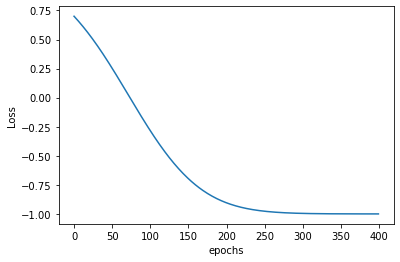

In [22]:
plt.plot(loss_hist)
plt.ylabel("Loss")
plt.xlabel("epochs")

## Conclusion 

Note that the value of the cost function 
is bounded between $-1$ and $1$ because
we take the expectation value with 
respect to the Pauli-Z 
operator. This expectation 
value of a state $\psi$
with respect to $\sigma_{z}$
is

\begin{equation}
\langle \psi| \sigma_{z} |\psi\rangle
\end{equation}


And it is well-known that 

\begin{equation}
\sigma_{z}|0\rangle = |0\rangle \\
\sigma_{z} |1\rangle = -|1\rangle
\end{equation}

We see in the graph that the loss starts 
off bad from around $0.75$ (when the worse
it could get was $1$). During the 
optimization routine, the loss progressively
gets down in $400$ epochs to very close to
$-1$. which was the best one could expect.